In [1]:
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
import math
import numpy as np
import sklearn.cluster as skclust 
import copy
import scipy.stats as spstat

def load_all_fitnesses(filename,obj) :
    with open(filename) as file :
        csv_data = csv.reader(file,delimiter=',')
        best_fitnesses = []
        best_ind_id = []
        avg_fitnesses = []
        pop_size= []
        nb_eval = []
        nb_eval_tot = 0
        for row in csv_data :
            best_fitness = 0
            best_id = 0
            avg_fitness = 0
            nb_eval_tot += int(row[1])
            for i in range(3,len(row[:-1]),int(row[2])) :
                if(float(row[i+obj]) > best_fitness) :
                    best_fitness = float(row[i+obj])
                    best_id = int(i/int(row[2]) - 1)
                avg_fitness += float(row[i+obj])
            avg_fitness = avg_fitness/float(row[1])
            avg_fitnesses.append(avg_fitness)
            best_fitnesses.append(best_fitness)
            best_ind_id.append(best_id)
            nb_eval.append(nb_eval_tot)
            pop_size.append(int(row[1]))
            
    return nb_eval, best_ind_id, best_fitnesses, avg_fitnesses, pop_size

def load_ind_fitnesses(filename):
    with open(filename) as file:
        csv_data = csv.reader(file,delimiter=',')
        lines = []
        for row in csv_data:
            for i in range(3,int(row[1])+3):
                lines.append([int(row[0]),i-3,float(row[i])])
    return lines

def load_controller_archive(filename):
    lines = []
    with open(filename) as file :
        csv_data = csv.reader(file,delimiter=',')
        coord = [0]*3
        state = 0
        nbr_param = 0
        i=0
        for row in csv_data:
            if(len(row) == 3):
                coord[0] = int(row[0])
                coord[1] = int(row[1])
                coord[2] = int(row[2])
                state = 1
                i=0
            elif(state == 1):
                nbr_param = int(row[0])
                state = 2
            elif(state == 2):
                nbr_param += int(row[0])
                state = 3
            elif(state == 3 and i < nbr_param):
                i+=1
            elif(state == 3 and i >= nbr_param):
                lines.append([coord[0],coord[1],coord[2],float(row[0])])
    return pd.DataFrame(data=lines,columns=["number of wheels","number of joints","number of sensors","fitness"])
                
def load_number_of_eval_per_gen(foldername,nbr_gen):
    nbr_eval_per_gen = [0]*nbr_gen
    for filename in os.listdir(foldername):
        if(filename.split('_')[0] != "controllers"):
            continue
        gen = int(filename.split('_')[1])
        with open(foldername + '/' + filename) as file:
            csv_data = csv.reader(file,delimiter=',')
            nbr_eval = 0
            for row in csv_data:
                if(len(row) == 4):
                    nbr_eval+=1
        nbr_eval_per_gen[gen] += nbr_eval
   # for i in range(1,len(nbr_eval_per_gen)):
    #    nbr_eval_per_gen[i] += nbr_eval_per_gen[i-1]
    return nbr_eval_per_gen
    
def load_controllers_fitnesses(foldername,nbr_gen):
    init_fits = [[] for _ in range(nbr_gen)]
    best_fits = [[] for _ in range(nbr_gen)]
    learn_prog = [[] for _ in range(nbr_gen)]
    learn_delta = [[] for _ in range(nbr_gen)]
    for filename in os.listdir(foldername):
        if(filename.split('_')[0] != "controllers"):
            continue
        gen = int(filename.split('_')[1])
        
        with open(foldername + '/' + filename) as file:
            csv_data = csv.reader(file,delimiter=',')
            best_fit = 0
            init_fit = 0
            counter = 0
            for row in csv_data:
                if(len(row) == 2):
                    if(init_fit == 0):
                        init_fit = float(row[0])
                        if(init_fit < 0):
                            init_fit = 0.5
                    if(best_fit < float(row[0])):
                        best_fit = float(row[0])
                    counter+=1
            learn_prog[gen].append((best_fit - init_fit))
            learn_delta[gen].append((best_fit - init_fit)/counter)
            best_fits[gen].append(best_fit)
            init_fits[gen].append(init_fit)
            
        
    return best_fits, init_fits ,learn_delta, learn_prog    
    
    
def load_descriptor(filename) :
    '''
    Load a list of descriptor from a file
    Trait descriptor: <width,depth,height,voxels,wheels,sensor,joint,caster>
    '''
    with open(filename) as file :
        csv_data = csv.reader(file,delimiter=',')
        descriptors = []
        for row in csv_data :
            desc = []
            for i in range(len(row)-1) :
                desc.append(float(row[i]))
            descriptors.append(desc)
        return descriptors
    
def descOneId_to_descTwoIds(descriptors,pop_size):
    descriptors2 = []
    gen = 0
    ind = 0
    for desc in descriptors:
        if(desc[0] != 0 and desc[0]%pop_size == 0):
            gen+=1
            ind=0
        desc2 = [gen,ind] + desc[1:]
        ind+=1
        descriptors2.append(desc2)
    return descriptors2
        
def descriptors_to_nbr_of_types(descriptors):
    types_lines = []
    acc = 0
    mat = [[[0 for _ in range(16)] for _ in range(16)] for _ in range(16)]
    for desc in descriptors:
        if(mat[int(desc[5]*16)][int(desc[6]*16)][int(desc[7]*16)] == 0):
            mat[int(desc[5]*16)][int(desc[6]*16)][int(desc[7]*16)] = 1
            acc+=1
        if(desc[1] == 0):
            type_lines.append([desc[0],acc])
    return type_lines

def sparsness_per_gen(descriptors,pop_size):
    sparsness = []
    for i in range(int(len(descriptors)/pop_size)):
        tmp_desc = descriptors[i*pop_size:(i+1)*pop_size]
        spars = 0
        for o in range(len(tmp_desc)):
            for p in range(len(tmp_desc)):
                if(o==p):
                    continue
                dist = np.linalg.norm(np.array(tmp_desc[o][3:])-np.array(tmp_desc[p][3:]))
            spars += dist
        sparsness.append([i,spars/10])
    return sparsness

def read_parameters(filename):
    '''
    Read a parameter and return a dictionnary
    '''
    parameters = dict()
    with open(filename) as file :
        csv_data = csv.reader(file,delimiter=',')
        for row in csv_data:
            parameters[row[0]] = row[2]
    return parameters

def plot_hist_nbr_rob(title,data,organ,bins,nb_rob):
    fig = plt.gcf()
    fig.set_size_inches(25,10)
    ax = sns.histplot(data=data,multiple="stack",bins=bins,x='gen',hue=organ,palette="light:b")
    ax.set_ylabel("Number of robots",fontsize=20)
    ax.set_xlabel("Generations",fontsize=20)
    plt.title(title,fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(range(1,nb_rob+1),labels=[1]*nb_rob,fontsize=20)
    plt.show()
    
    
def acc_number_eval(nbr_eval, best_fit):
    acc_nbr_eval = [0]
    for ne in nbr_eval:
        acc_nbr_eval.append(acc_nbr_eval[-1]+ne)
    for ne,fit in zip(acc_nbr_eval,best_fit):
        if(fit >= 0.95):
            return acc_nbr_eval, ne
        
def fitness_per_descriptor(descriptors,fitnesses):
    fit_per_desc = [dict() for _ in range(int(len(fitnesses)/20))]
    for fit,desc in zip(fitnesses,descriptors):
        if(fit[0] == desc[0] and fit[1] == desc[1]):
            organ_desc = str(int(desc[6]*16))+str(int(desc[7]*16)) + str(int(desc[8]*16))
            if(organ_desc in fit_per_desc[fit[0]]):
                fit_per_desc[fit[0]][organ_desc].append(fit[2])
            else:
                fit_per_desc[fit[0]][organ_desc] = [fit[2]]
    return fit_per_desc

def best_desc_per_gen(descriptors,fitnesses):
    best_fit = 0
    best_idx = 0
    best_desc = []
    for fit,i in zip(fitnesses,range(len(fitnesses))):
        if(fit[1] == 0 and fit[0] != 0):
            best_fit = 0
            best_desc.append([fit[0]-1,int(descriptors[best_idx][6]*16),int(descriptors[best_idx][7]*16),int(descriptors[best_idx][8]*16)])         
        if(fit[2] > best_fit):
            best_fit = fit[2]
            best_idx = i

    return best_desc
                     

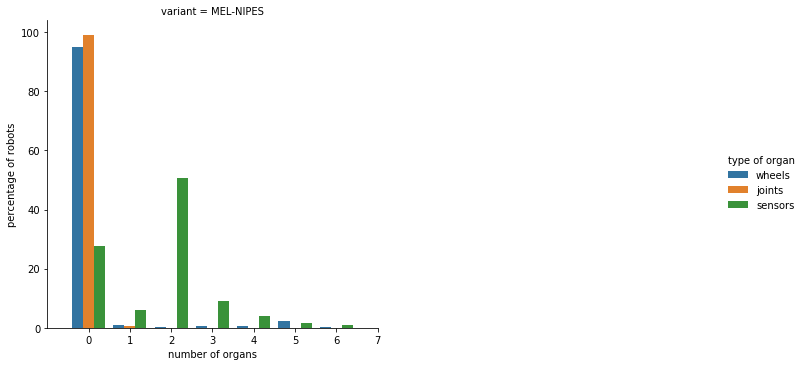

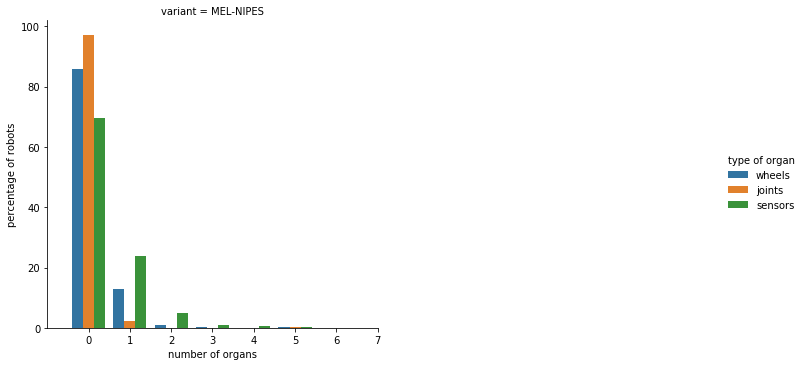

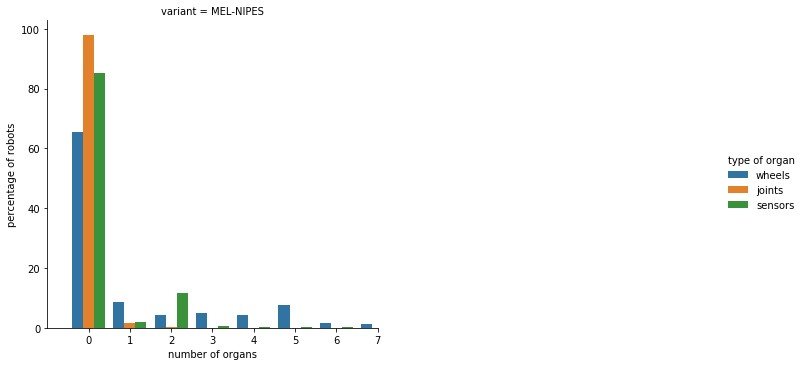

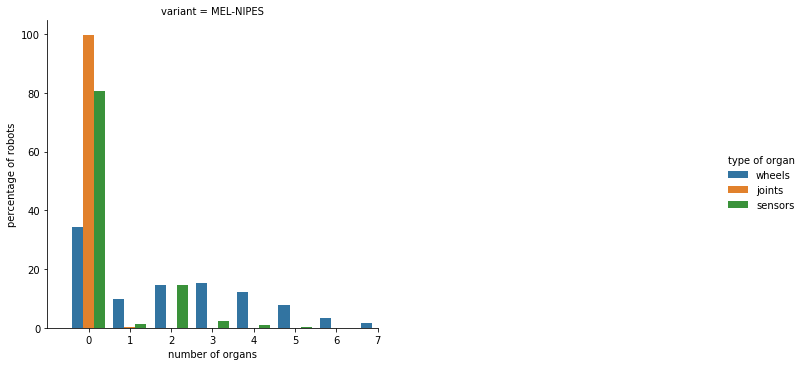

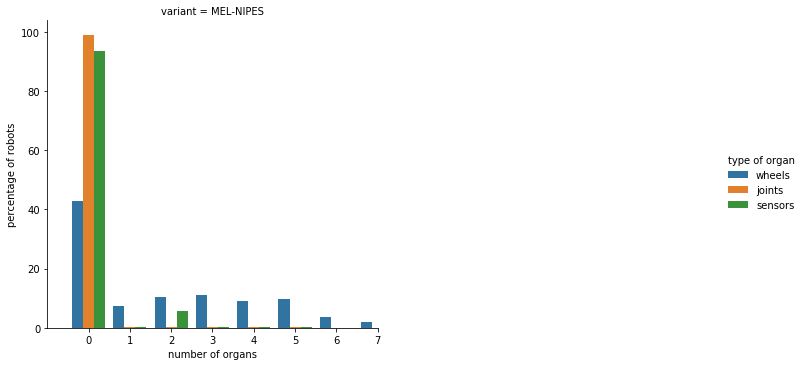

In [13]:
exp_folder = "/home/leni/are-logs/nn2_cppn_test_1/"

type_lines = []
best_desc_lines = []
for folder in os.listdir(exp_folder):
    organ_lines = []
    desc_lines = []
    fit_lines = []
    descriptors = load_descriptor(exp_folder + folder + "/MD_Cart_WDH.csv")
    type_lines += descriptors_to_nbr_of_types(descriptors)
    fitnesses = load_ind_fitnesses(exp_folder + folder + "/fitnesses.csv")
    fit_lines += fitnesses
    best_desc_lines += best_desc_per_gen(descriptors,fitnesses)
    for desc in descriptors:
        desc_lines.append([desc[0],str(desc[1]),desc[5]*16,desc[6]*16,desc[7]*16])
        
    wheels = [0 for _ in range(16)]
    joints = [0 for _ in range(16)]
    sensors = [0 for _ in range(16)]

    total=0
    for fit,desc in zip(fit_lines,desc_lines):
        wheels[int(desc[2])]+=1
        joints[int(desc[4])]+=1
        sensors[int(desc[3])]+=1
        total+=1

    for i in range(len(wheels)):
        wheels[i]=wheels[i]/total*100
        joints[i]=joints[i]/total*100
        sensors[i]=sensors[i]/total*100


    for i,w in zip(range(len(wheels)),wheels):
        organ_lines.append([str(i),w,"wheels","MEL-NIPES"])
    for i,j in zip(range(len(joints)),joints):
        organ_lines.append([str(i),j,"joints","MEL-NIPES"])
    for i,s in zip(range(len(sensors)),sensors):
        organ_lines.append([str(i),s,"sensors","MEL-NIPES"])
    
    organs_data = pd.DataFrame(data=organ_lines,columns=["number of organs","percentage of robots","type of organ","variant"])
    g=sns.catplot(data=organs_data,x="number of organs",y="percentage of robots",hue="type of organ",col="variant",kind='bar',col_wrap=2)
    g.set(xlim=[-1,7])

bodyplantesting_nn2_12_4_9-51-25-5445-3480022976
bodyplantesting_nn2_12_4_9-51-26-6629-4238963474
bodyplantesting_nn2_12_4_9-49-5-5770-4103278712
bodyplantesting_nn2_12_4_9-48-58-8368-1372236020
bodyplantesting_nn2_12_4_9-51-33-3572-1951416143


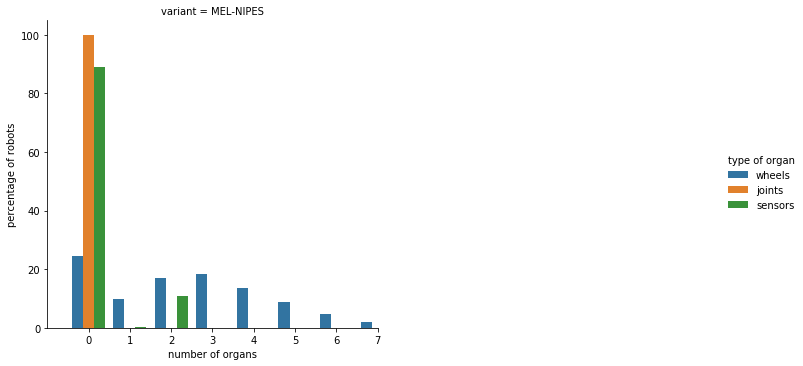

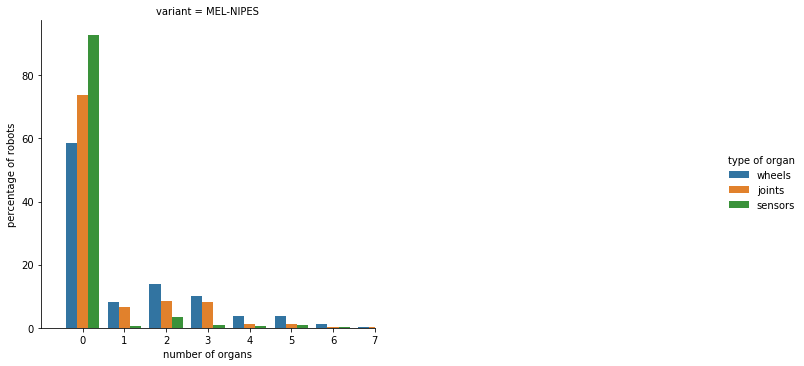

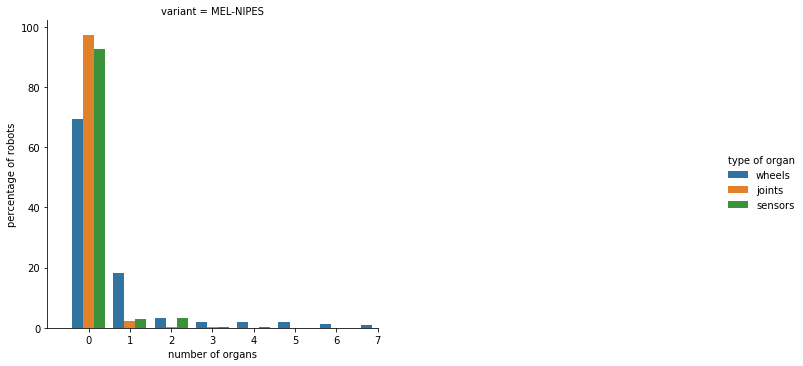

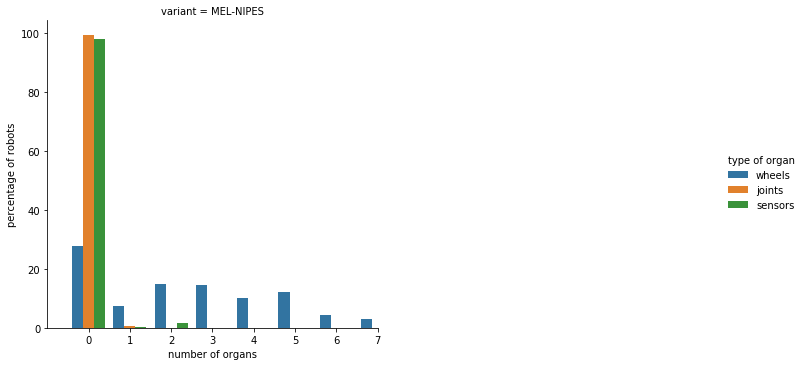

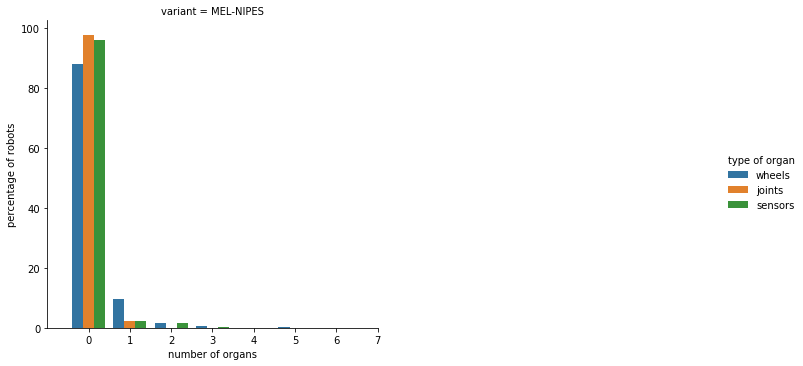

In [15]:
exp_folder = "/home/leni/are-logs/nn2_cppn_test_2/"

type_lines = []
best_desc_lines = []
for folder in os.listdir(exp_folder):
    print(folder)
    organ_lines = []
    desc_lines = []
    fit_lines = []
    descriptors = load_descriptor(exp_folder + folder + "/MD_Cart_WDH.csv")
    type_lines += descriptors_to_nbr_of_types(descriptors)
    fitnesses = load_ind_fitnesses(exp_folder + folder + "/fitnesses.csv")
    fit_lines += fitnesses
    best_desc_lines += best_desc_per_gen(descriptors,fitnesses)
    for desc in descriptors:
        desc_lines.append([desc[0],str(desc[1]),desc[5]*16,desc[6]*16,desc[7]*16])
        
    wheels = [0 for _ in range(16)]
    joints = [0 for _ in range(16)]
    sensors = [0 for _ in range(16)]

    total=0
    for fit,desc in zip(fit_lines,desc_lines):
        wheels[int(desc[2])]+=1
        joints[int(desc[4])]+=1
        sensors[int(desc[3])]+=1
        total+=1

    for i in range(len(wheels)):
        wheels[i]=wheels[i]/total*100
        joints[i]=joints[i]/total*100
        sensors[i]=sensors[i]/total*100


    for i,w in zip(range(len(wheels)),wheels):
        organ_lines.append([str(i),w,"wheels","MEL-NIPES"])
    for i,j in zip(range(len(joints)),joints):
        organ_lines.append([str(i),j,"joints","MEL-NIPES"])
    for i,s in zip(range(len(sensors)),sensors):
        organ_lines.append([str(i),s,"sensors","MEL-NIPES"])
    
    organs_data = pd.DataFrame(data=organ_lines,columns=["number of organs","percentage of robots","type of organ","variant"])
    g=sns.catplot(data=organs_data,x="number of organs",y="percentage of robots",hue="type of organ",col="variant",kind='bar',col_wrap=2)
    g.set(xlim=[-1,7])

bodyplantesting_nn2_11_4_14-30-58-8846-1353968468
bodyplantesting_nn2_11_4_14-31-0-882-4126189499
bodyplantesting_nn2_11_4_14-30-59-9792-1517957088
bodyplantesting_nn2_11_4_14-33-16-6509-518278973
bodyplantesting_nn2_11_4_14-31-5-5885-1301095223
bodyplantesting_nn2_11_4_14-30-47-7753-2241497167


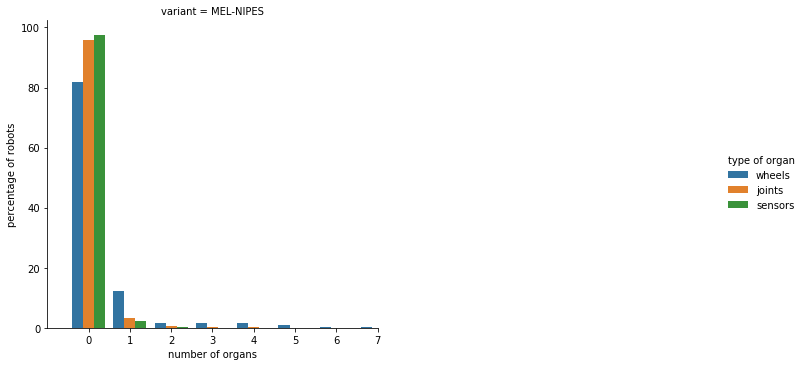

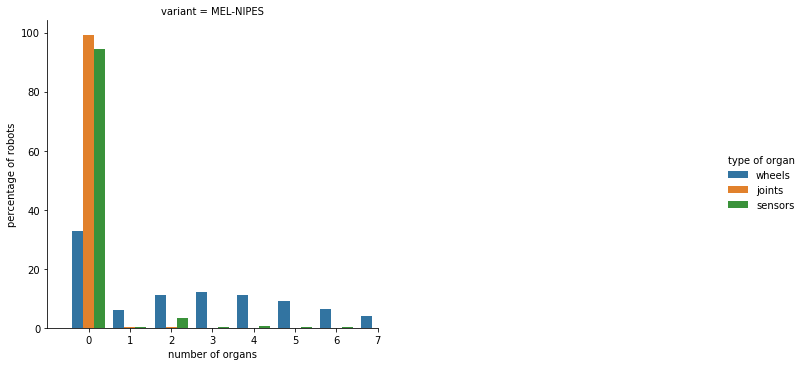

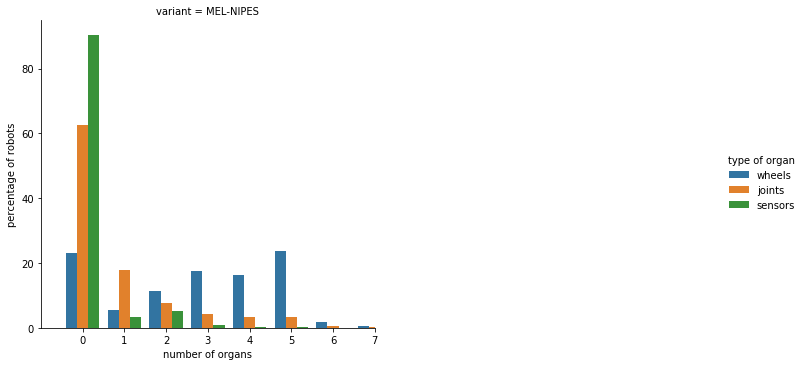

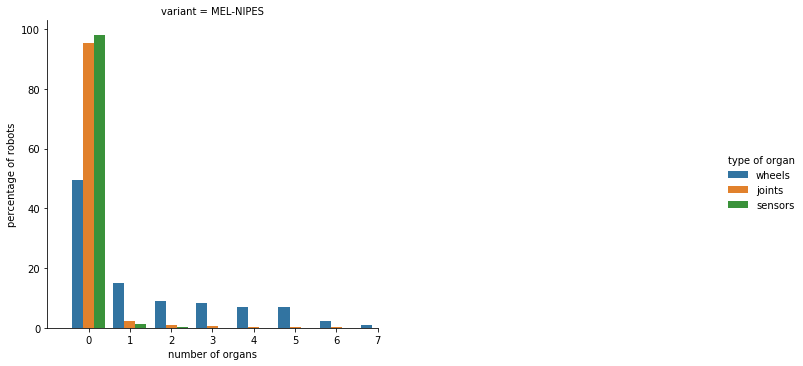

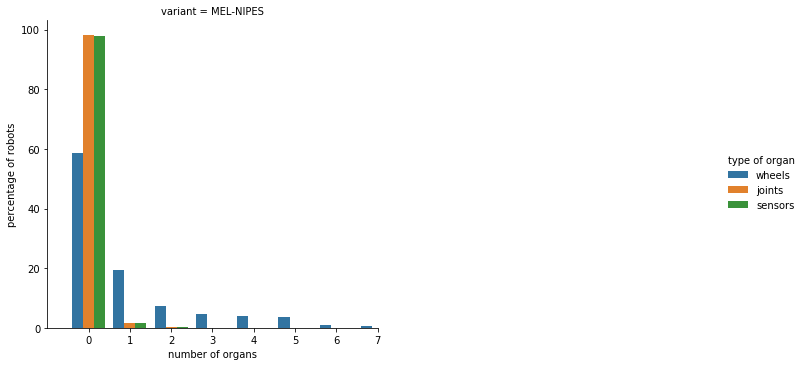

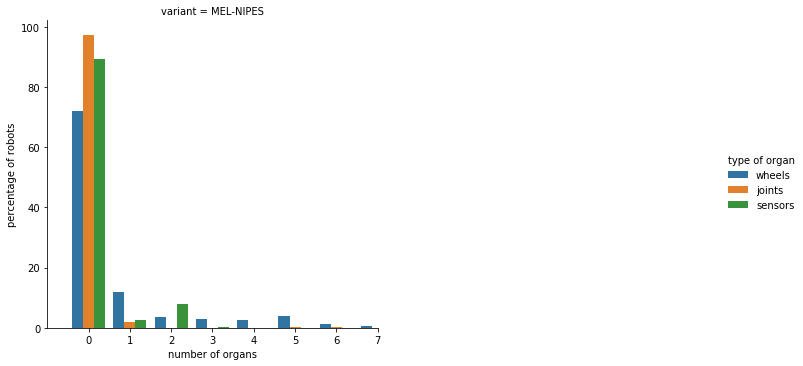

In [16]:
exp_folder = "/home/leni/are-logs/nn2_cppn_test_1_5/"

type_lines = []
best_desc_lines = []
for folder in os.listdir(exp_folder):
    print(folder)
    organ_lines = []
    desc_lines = []
    fit_lines = []
    descriptors = load_descriptor(exp_folder + folder + "/MD_Cart_WDH.csv")
    type_lines += descriptors_to_nbr_of_types(descriptors)
    fitnesses = load_ind_fitnesses(exp_folder + folder + "/fitnesses.csv")
    fit_lines += fitnesses
    best_desc_lines += best_desc_per_gen(descriptors,fitnesses)
    for desc in descriptors:
        desc_lines.append([desc[0],str(desc[1]),desc[5]*16,desc[6]*16,desc[7]*16])
        
    wheels = [0 for _ in range(16)]
    joints = [0 for _ in range(16)]
    sensors = [0 for _ in range(16)]

    total=0
    for fit,desc in zip(fit_lines,desc_lines):
        wheels[int(desc[2])]+=1
        joints[int(desc[4])]+=1
        sensors[int(desc[3])]+=1
        total+=1

    for i in range(len(wheels)):
        wheels[i]=wheels[i]/total*100
        joints[i]=joints[i]/total*100
        sensors[i]=sensors[i]/total*100


    for i,w in zip(range(len(wheels)),wheels):
        organ_lines.append([str(i),w,"wheels","MEL-NIPES"])
    for i,j in zip(range(len(joints)),joints):
        organ_lines.append([str(i),j,"joints","MEL-NIPES"])
    for i,s in zip(range(len(sensors)),sensors):
        organ_lines.append([str(i),s,"sensors","MEL-NIPES"])
    
    organs_data = pd.DataFrame(data=organ_lines,columns=["number of organs","percentage of robots","type of organ","variant"])
    g=sns.catplot(data=organs_data,x="number of organs",y="percentage of robots",hue="type of organ",col="variant",kind='bar',col_wrap=2)
    g.set(xlim=[-1,7])

bodyplantesting_nn2_18_4_8-12-59-9345-4019763161
bodyplantesting_nn2_17_4_15-35-26-6699-3308984963
bodyplantesting_nn2_17_4_15-35-26-6550-1832857523
bodyplantesting_nn2_17_4_15-35-18-8200-1329287865
bodyplantesting_nn2_18_4_8-15-7-7339-3041856169
bodyplantesting_nn2_17_4_15-35-15-5176-483145514
bodyplantesting_nn2_18_4_8-12-55-5117-1219177500
bodyplantesting_nn2_17_4_15-35-25-5599-1169654133
bodyplantesting_nn2_18_4_8-12-57-7106-1342178671
bodyplantesting_nn2_18_4_8-12-58-8054-3711147932


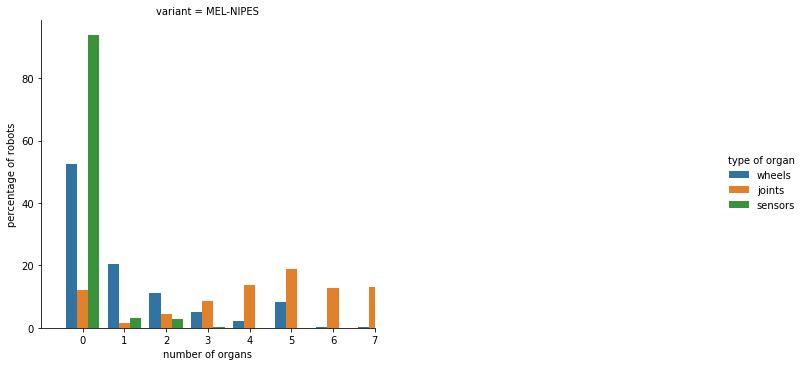

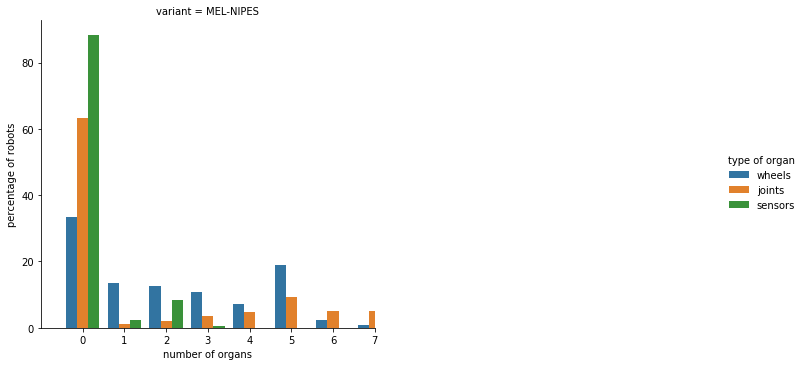

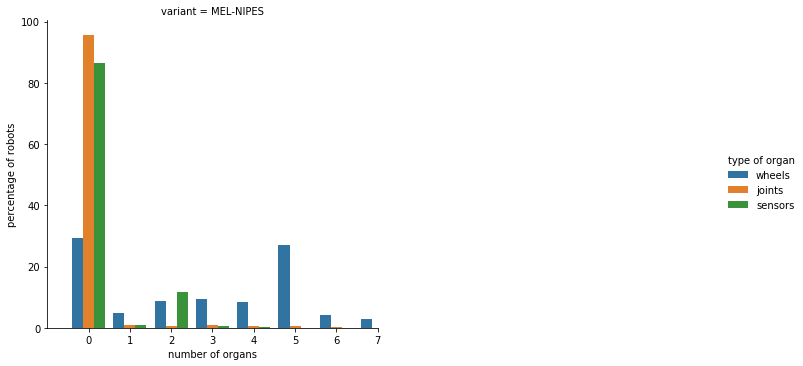

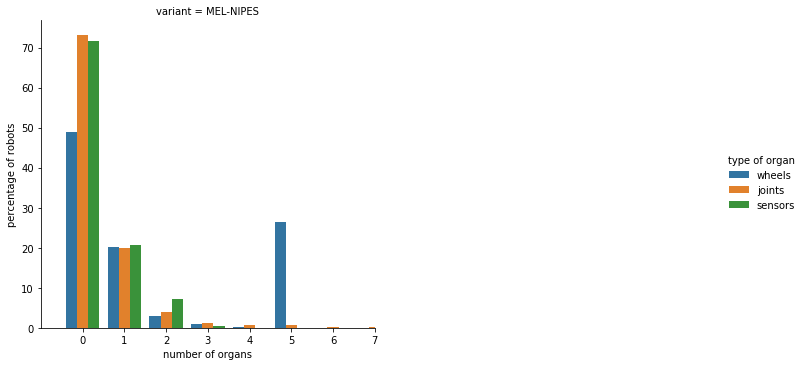

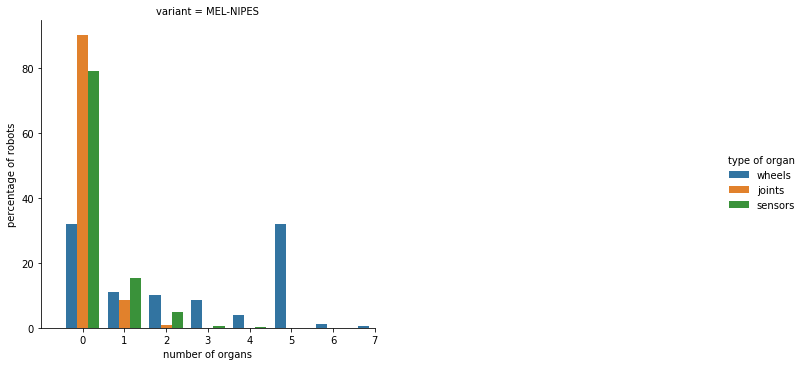

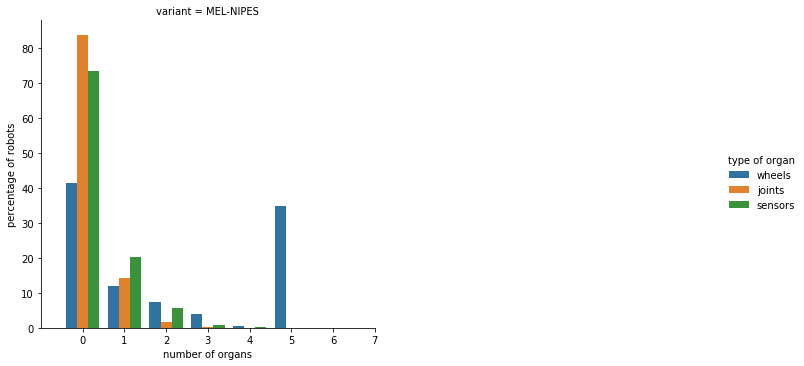

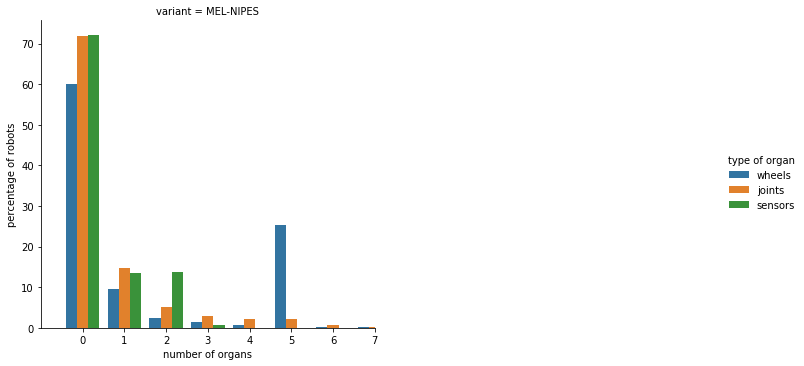

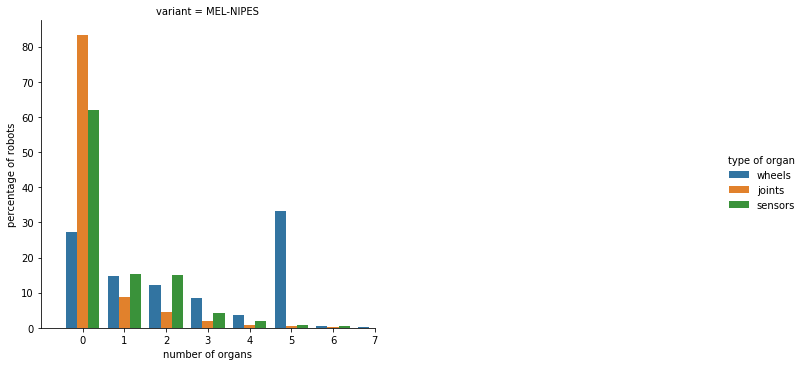

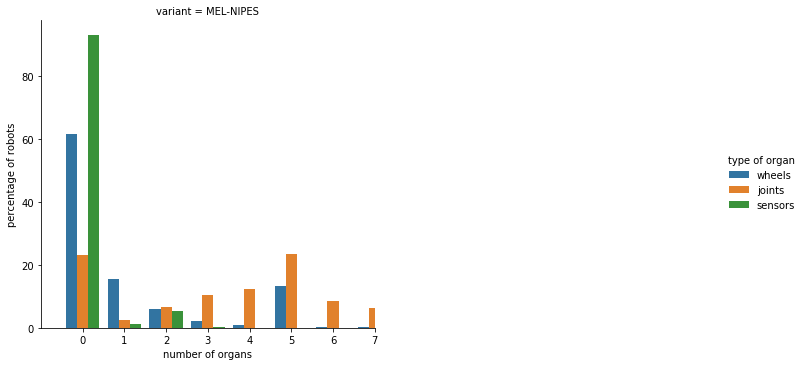

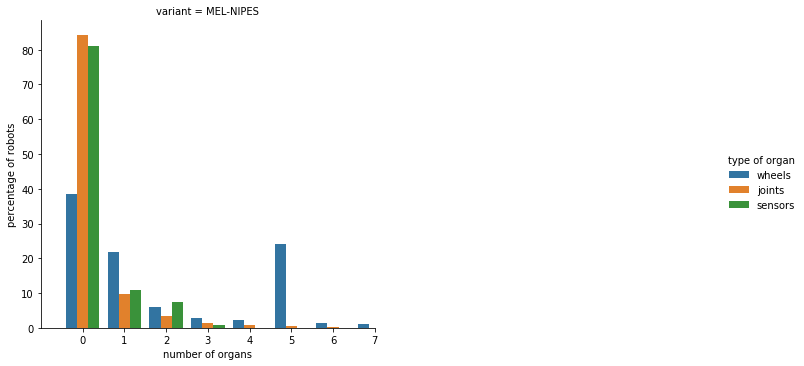

In [5]:
exp_folder = "/home/leni/are-logs/nn2_cppn_test_3/"

type_lines = []
best_desc_lines = []
for folder in os.listdir(exp_folder):
    print(folder)
    organ_lines = []
    desc_lines = []
    fit_lines = []
    descriptors = load_descriptor(exp_folder + folder + "/MD_Cart_WDH.csv")
    type_lines += descriptors_to_nbr_of_types(descriptors)
    fitnesses = load_ind_fitnesses(exp_folder + folder + "/fitnesses.csv")
    fit_lines += fitnesses
    best_desc_lines += best_desc_per_gen(descriptors,fitnesses)
    for desc in descriptors:
        desc_lines.append([desc[0],str(desc[1]),desc[5]*16,desc[6]*16,desc[7]*16])
        
    wheels = [0 for _ in range(16)]
    joints = [0 for _ in range(16)]
    sensors = [0 for _ in range(16)]

    total=0
    for fit,desc in zip(fit_lines,desc_lines):
        wheels[int(desc[2])]+=1
        joints[int(desc[4])]+=1
        sensors[int(desc[3])]+=1
        total+=1

    for i in range(len(wheels)):
        wheels[i]=wheels[i]/total*100
        joints[i]=joints[i]/total*100
        sensors[i]=sensors[i]/total*100


    for i,w in zip(range(len(wheels)),wheels):
        organ_lines.append([str(i),w,"wheels","MEL-NIPES"])
    for i,j in zip(range(len(joints)),joints):
        organ_lines.append([str(i),j,"joints","MEL-NIPES"])
    for i,s in zip(range(len(sensors)),sensors):
        organ_lines.append([str(i),s,"sensors","MEL-NIPES"])
    
    organs_data = pd.DataFrame(data=organ_lines,columns=["number of organs","percentage of robots","type of organ","variant"])
    g=sns.catplot(data=organs_data,x="number of organs",y="percentage of robots",hue="type of organ",col="variant",kind='bar',col_wrap=2)
    g.set(xlim=[-1,7])

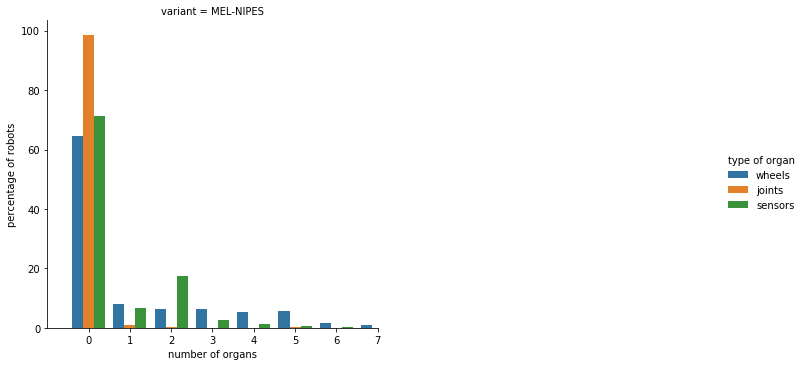

In [10]:
organs_data = pd.DataFrame(data=organ_lines,columns=["number of organs","percentage of robots","type of organ","variant"])
g=sns.catplot(data=organs_data,x="number of organs",y="percentage of robots",hue="type of organ",col="variant",kind='bar',col_wrap=2)
g.set(xlim=[-1,7])

In [11]:
exp_folder = "/home/leni/are-logs/nn2_cppn_test_2/"
organ_lines = []
fit_lines = []
desc_lines = []
type_lines = []
best_desc_lines = []
for folder in os.listdir(exp_folder):
    descriptors = load_descriptor(exp_folder + folder + "/MD_Cart_WDH.csv")
    type_lines += descriptors_to_nbr_of_types(descriptors)
    fitnesses = load_ind_fitnesses(exp_folder + folder + "/fitnesses.csv")
    fit_lines += fitnesses
    best_desc_lines += best_desc_per_gen(descriptors,fitnesses)
    for desc in descriptors:
        desc_lines.append([desc[0],str(desc[1]),desc[5]*16,desc[6]*16,desc[7]*16])
        
wheels = [0 for _ in range(16)]
joints = [0 for _ in range(16)]
sensors = [0 for _ in range(16)]

total=0
for fit,desc in zip(fit_lines,desc_lines):
        wheels[int(desc[2])]+=1
        joints[int(desc[4])]+=1
        sensors[int(desc[3])]+=1
        total+=1

for i in range(len(wheels)):
    wheels[i]=wheels[i]/total*100
    joints[i]=joints[i]/total*100
    sensors[i]=sensors[i]/total*100


for i,w in zip(range(len(wheels)),wheels):
    organ_lines.append([str(i),w,"wheels","MEL-NIPES"])
for i,j in zip(range(len(joints)),joints):
    organ_lines.append([str(i),j,"joints","MEL-NIPES"])
for i,s in zip(range(len(sensors)),sensors):
    organ_lines.append([str(i),s,"sensors","MEL-NIPES"])

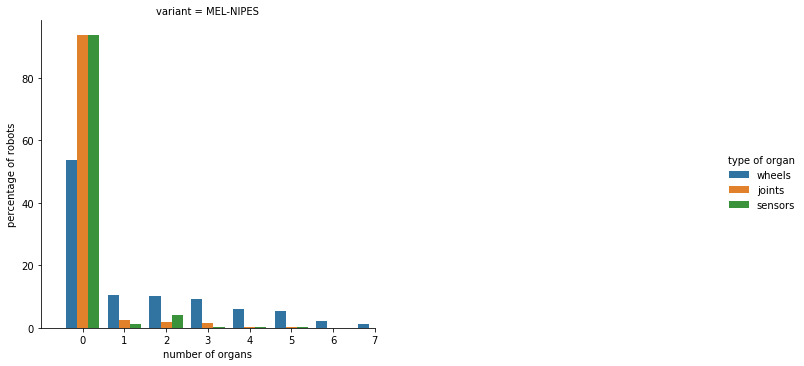

In [12]:
organs_data = pd.DataFrame(data=organ_lines,columns=["number of organs","percentage of robots","type of organ","variant"])
g=sns.catplot(data=organs_data,x="number of organs",y="percentage of robots",hue="type of organ",col="variant",kind='bar',col_wrap=2)
g.set(xlim=[-1,7])

In [6]:
exp_folder = "/home/leni/are-logs/nn2_cppn_test_3/"
organ_lines = []
fit_lines = []
desc_lines = []
type_lines = []
best_desc_lines = []
for folder in os.listdir(exp_folder):
    descriptors = load_descriptor(exp_folder + folder + "/MD_Cart_WDH.csv")
    type_lines += descriptors_to_nbr_of_types(descriptors)
    fitnesses = load_ind_fitnesses(exp_folder + folder + "/fitnesses.csv")
    fit_lines += fitnesses
    best_desc_lines += best_desc_per_gen(descriptors,fitnesses)
    for desc in descriptors:
        desc_lines.append([desc[0],str(desc[1]),desc[5]*16,desc[6]*16,desc[7]*16])
        
wheels = [0 for _ in range(16)]
joints = [0 for _ in range(16)]
sensors = [0 for _ in range(16)]

total=0
for fit,desc in zip(fit_lines,desc_lines):
        wheels[int(desc[2])]+=1
        joints[int(desc[4])]+=1
        sensors[int(desc[3])]+=1
        total+=1

for i in range(len(wheels)):
    wheels[i]=wheels[i]/total*100
    joints[i]=joints[i]/total*100
    sensors[i]=sensors[i]/total*100


for i,w in zip(range(len(wheels)),wheels):
    organ_lines.append([str(i),w,"wheels","MEL-NIPES"])
for i,j in zip(range(len(joints)),joints):
    organ_lines.append([str(i),j,"joints","MEL-NIPES"])
for i,s in zip(range(len(sensors)),sensors):
    organ_lines.append([str(i),s,"sensors","MEL-NIPES"])

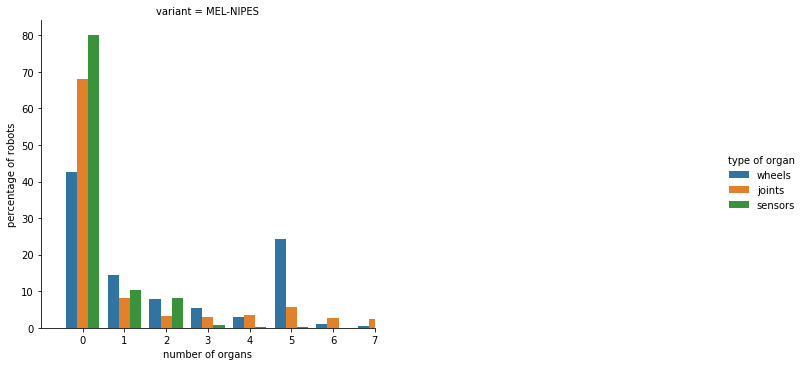

In [7]:
organs_data = pd.DataFrame(data=organ_lines,columns=["number of organs","percentage of robots","type of organ","variant"])
g=sns.catplot(data=organs_data,x="number of organs",y="percentage of robots",hue="type of organ",col="variant",kind='bar',col_wrap=2)
g.set(xlim=[-1,7])